In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Dataframe formation

In [2]:
# countdown of the operation execution time 
start_time = time()  

# generating a list of folder names containing csv files
path_to_new_folder_with_data = "tabs"
list_with_folders_names = glob.glob(path_to_new_folder_with_data + f'\\*')  

# formation of a common dataframe from data contained in csv files
total_frame = pd.DataFrame()

for i in tqdm(list_with_folders_names, leave=False, desc='concatenation'):
    list_with_file_csv_names = glob.glob(i + f'\\*.csv') 
    
    for j in list_with_file_csv_names:
        
        # loading and processing data from each csv file 
        intermediate_dataset = pd.read_csv(j, encoding='utf-8', skiprows=[i for i in range(6)], usecols=[i for i in range(12)])
        intermediate_dataset = intermediate_dataset.rename(columns={'Number': 'Number of deaths'})
        intermediate_dataset['Cause of death'] = i.split('\\')[-1]
        intermediate_dataset = intermediate_dataset[['Cause of death', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age Group', 'Number of deaths', \
                                                     'Death rate per 100 000 population', 'Percentage of cause-specific deaths out of total deaths', \
                                                     'Age-standardized death rate per 100 000 standard population']]
        intermediate_dataset['Sex'] = intermediate_dataset['Sex'].apply(lambda a: 'Both' if a == 'All' else a)

        # attaching data from each csv file to a common dataframe
        total_frame = pd.concat([total_frame, intermediate_dataset], ignore_index=True)

# saving a common dataframe
path_to_file_with_total_frame = path_to_new_folder_with_data + f'\\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv'
total_frame.to_csv(path_to_file_with_total_frame, index=False)

# printing of the time spent on the execution of the operation
print(f'time: {time() - start_time}')

time: 201.46574187278748


## Data checking

In [7]:
# loading the previously formed dataframe 
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')
#df.info()

### Checking the equality of the declared and calculated values of the number of deaths ("Number of deaths")

#### Checking the equality of reported and calculated values of the number of deaths for both sexes   
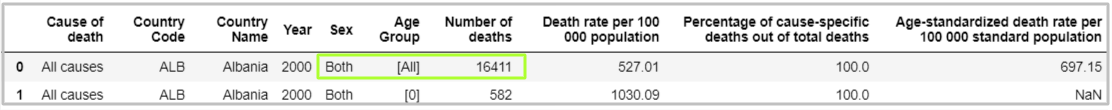

In [8]:
# loading the previously formed dataframe 
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')
df = df.loc[::, 'Cause of death':'Number of deaths']
df = df.drop(['Country Code'], axis=1) 

# calculation of the number of deaths by both sexes
year_sum = df[(df['Sex'] != 'Both') & (df['Age Group'] != '[All]')] 
year_sum = year_sum.groupby(['Cause of death', 'Country Name', 'Year']).agg({'Number of deaths':'sum'})
year_sum = year_sum.rename(columns={'Number of deaths':'Calculating Both'})
year_sum

# reported deaths by both sexes
year_sum_original = df[(df['Sex'] == 'Both') & (df['Age Group'] == '[All]')].set_index(['Cause of death', 'Country Name', 'Year'])
year_sum_original = year_sum_original.drop(['Sex', 'Age Group'], axis=1)
year_sum_original = year_sum_original.rename(columns={'Number of deaths':'Original Both'})
year_sum_original

difference_year = len(year_sum_original) - len(year_sum)

## a difference was found in the dimension of dataframes containing the estimated and declared numbers of deaths for both sexes
## it is necessary to find out the reason for the discrepancy between dimensions

# getting rid of indexes in dataframes with calculated and declared values
year_sum = year_sum.reset_index()
year_sum_original = year_sum_original.reset_index() 

# combining dataframes with calculated and declared values
find_error_df = pd.concat([year_sum_original, year_sum], axis=1)

# rows with matching column values "Cause of death", "Country Name", "Year"
find_error_df[(find_error_df.iloc[:, 0]==find_error_df.iloc[:, 4]) & (find_error_df.iloc[:, 1]==find_error_df.iloc[:, 5]) & \
              (find_error_df.iloc[:, 2]==find_error_df.iloc[:, 6])]
find_error_df.loc[358:363, ::]

## duplicate lines detected 

# duplicate rows in original dataframe
year_sum_original[year_sum_original.duplicated()] 

# checking if the number of duplicates in the original dataframe is equal to the difference in the lengths of the dataframes containing the estimated and declared numbers of deaths for both sexes
len(year_sum_original[year_sum_original.duplicated()]) == difference_year

True

In the course of the compliance check of the declared and calculated values of the number of deaths for both sexes, it was revealed that:
- there are discrepancies between declared and actual values of total numbers of deaths;
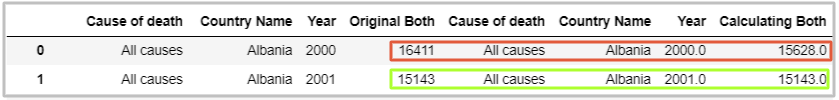
- there is an error that occurred when downloading data from the WHO resource. While the script was running, 12 files were downloaded, duplicating the previously downloaded ones. It is required to make changes to the Wb Scraper script and re-download the entire data array. 

In [9]:
## changes have been made to the Web Scraper code. Added check of the downloaded csv file. The entire amount of data has been downloaded again

# check redownloaded dataframe
len(year_sum) == len(year_sum_original)

# removing duplicate columns 
find_error_df = find_error_df.iloc[::, [0, 1, 2, 3, 7]]

In [10]:
## analysis of discrepancy between reported and calculated values of the number of deaths by both sexes

# addition of columns characterizing discrepancies between reported and calculated values of the number of deaths for both sexes
find_error_df['Original Both equals Calculating Both'] = find_error_df['Original Both'] == find_error_df['Calculating Both']
find_error_df['Differences between Original Both and Calculating Both'] = find_error_df.apply(
    lambda row: abs(row['Original Both'] - row['Calculating Both']), axis=1)          

find_error_df[find_error_df['Differences between Original Both and Calculating Both'] != 0]
find_error_df[find_error_df['Original Both'] > find_error_df['Calculating Both']]
find_error_df['Differences between Original Both and Calculating Both'].describe()

find_error_df['Differences between Original Both and Calculating Both'].value_counts().sort_values(ascending = False)
find_error_df['Categories differences between Original Both and Calculating Both'] = pd.cut(
    find_error_df['Differences between Original Both and Calculating Both'], bins=[-1,0, 10, 100, 1000, float('inf')], \
    labels=['No difference', '<10', '<100', '<1000', '>1000'])

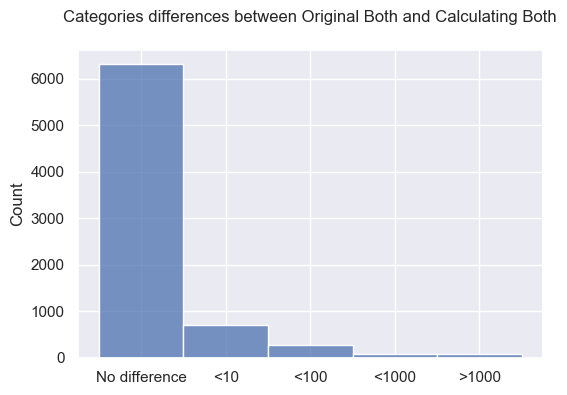

In [11]:
# visualization of the discrepancy between the declared and calculated values of the number of deaths for both sexes
sns.set (font_scale=1)
plt.figure(figsize=(6,4))
sns.histplot(find_error_df['Categories differences between Original Both and Calculating Both'])
plt.xlabel('')
plt.title('Categories differences between Original Both and Calculating Both', pad=20)
plt.show()

In [12]:
# addition of a column characterizing the percentage of declared and calculated values of the number of deaths for both sexes

find_error_df[find_error_df['Original Both equals Calculating Both']==False]
find_error_df[(find_error_df['Original Both equals Calculating Both']==False) & \
              (find_error_df['Original Both'] < find_error_df['Calculating Both'])]

find_error_df['Percent difference between Original Both and Calculating Both'] = find_error_df.apply(
    lambda row: round((row['Original Both'] - row['Calculating Both'])*100 / row['Original Both'], 2) \
    if row['Calculating Both']!=0 else 0, axis=1)
find_error_df['Percent difference between Original Both and Calculating Both'].value_counts().sort_values(ascending = False)

find_error_df['Categories percent difference between Original Both and Calculating Both'] = pd.cut(
    find_error_df['Percent difference between Original Both and Calculating Both'], bins=[-1,0, 1, 5, float('inf')], \
    labels=['No difference', '<1%', '<5%', '>5%'])

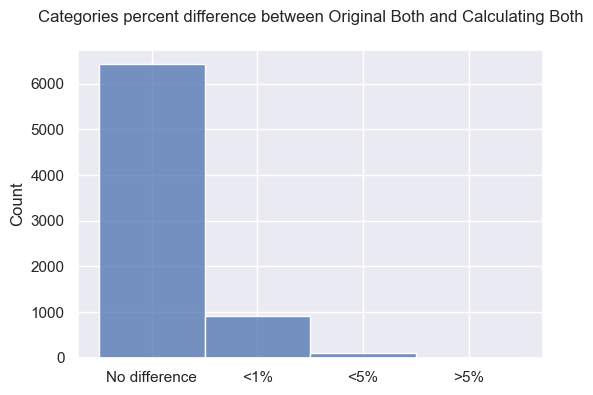

In [13]:
# visualization of percentages of declared and calculated values of the number of deaths for both sexes
sns.set (font_scale=1)
plt.figure(figsize=(6,4))
sns.histplot(find_error_df['Categories percent difference between Original Both and Calculating Both'])
plt.xlabel('')
plt.title('Categories percent difference between Original Both and Calculating Both', pad=20)
plt.show()

In [14]:
# countries with discrepancies between reported and estimated deaths for both sexes
country_with_differences  = find_error_df.groupby(['Country Name']).agg({'Original Both equals Calculating Both':'unique'})
country_with_differences['Original Both equals Calculating Both'] = country_with_differences[
    'Original Both equals Calculating Both'].apply(lambda el: [False, True] if list(el) == [True, False] else list(el))

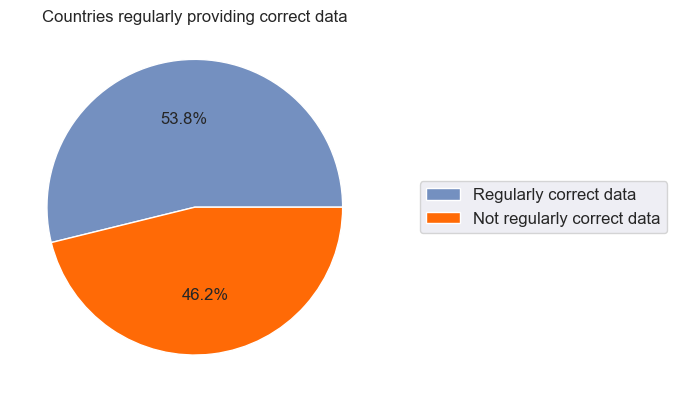

In [15]:
# visualization of the ratio of countries with and without differences in values
colors = [(116/255, 144/255, 192/255), (1,106/255,6/255)]
plt.pie(country_with_differences['Original Both equals Calculating Both'].value_counts(), radius=1.0, \
        autopct='%1.1f%%', colors=colors)
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5), \
           labels = ['Regularly correct data', 'Not regularly correct data'], fontsize = 12)
plt.title('Countries regularly providing correct data', pad=0.5)
plt.show()

In [16]:
## an attempt to find a dependencies between the presence of discrepancies and the year
year_with_differences = pd.pivot_table(find_error_df[find_error_df['Original Both equals Calculating Both']==False], \
                                       index = ['Cause of death', 'Year'], columns=['Country Name'], \
                                       values='Original Both equals Calculating Both', aggfunc='first')
year_with_differences.fillna('-')

## no dependencies found

Country Name                Albania Belarus Belgium Bosnia and Herzegovina  \
Cause of death         Year                                                  
All causes             2000   False   False       -                      -   
                       2001       -   False   False                      -   
                       2002   False   False       -                      -   
                       2003       -   False       -                      -   
                       2004       -       -   False                      -   
...                             ...     ...     ...                    ...   
Unintentional injuries 2017       -       -       -                      -   
                       2018       -   False       -                      -   
                       2019       -       -       -                      -   
                       2020       -       -       -                      -   
                       2021       -       -       -                      -   

Country Name                Croatia Estonia Greece Hungary  Italy Latvia  \
Cause of death         Year                                                
All causes             2000   False   False      -   False      -  False   
                       2001   False   False      -   False      -  False   
                       2002   False   False      -   False      -  False   
                       2003   False   False      -   False      -  False   
                       2004   False   False      -   False  False  False   
...                             ...     ...    ...     ...    ...    ...   
Unintentional injuries 2017   False       -  False   False  False      -   
                       2018       -       -      -       -  False      -   
                       2019   False   False  False   False  False      -   
                       2020       -   False  False       -      -      -   
                       2021       -       -      -       -      -      -   

Country Name                Lithuania Montenegro North Macedonia Portugal  \
Cause of death         Year                                                 
All causes             2000     False          -           False        -   
                       2001     False      False           False        -   
                       2002     False          -           False        -   
                       2003     False      False           False        -   
                       2004     False      False           False        -   
...                               ...        ...             ...      ...   
Unintentional injuries 2017         -          -               -    False   
                       2018         -          -               -        -   
                       2019         -          -               -        -   
                       2020         -          -               -        -   
                       2021         -          -               -        -   

Country Name                Russian Federation Serbia Ukraine  \
Cause of death         Year                                     
All causes             2000                  -  False   False   
                       2001              False  False   False   
                       2002              False  False   False   
                       2003              False  False   False   
                       2004              False  False   False   
...                                        ...    ...     ...   
Unintentional injuries 2017              False  False   False   
                       2018              False  False   False   
                       2019              False  False   False   
                       2020                  -  False       -   
                       2021                  -  False       -   

Country Name                United Kingdom of Great Britain and Northern Ireland  
Cause of death         Year                                      

Result: 
- During checking for discrepancies in the reported number of deaths across both sexes from each cause of death, a download error was identified resulting in a duplicate download of 12 CSV files. During the analysis of this problem, the dependencies  of its occurrence were not identified. This issue was addressed by adding a forced verification of the downloaded CSV file to the script;
- In most cases, the reported number of deaths by both sexes from each cause of death is equal to the estimated number. Information for 53% of countries contains information with corresponding death numbers. The data for the rest of the countries are not always equal;
- Dependence of the difference in the estimated and declared number of deaths from the year was not revealed.

#### Checking the equality of reported and calculated values of the number of deaths for each sex
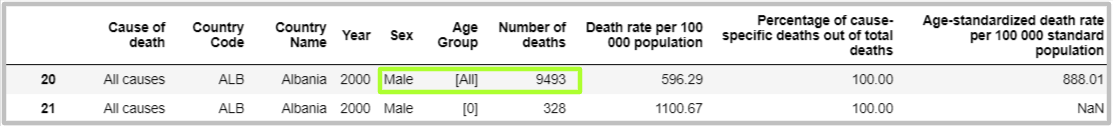

In [17]:
# loading the previously formed dataframe 
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')
df = df.loc[::, 'Cause of death':'Number of deaths']
df = df.drop(['Country Code'], axis=1) 

# calculation of the number of deaths for each sex
sex_sum = df[(df['Sex'] != 'Both') & (df['Age Group'] != '[All]')]
sex_sum = sex_sum.groupby(['Cause of death', 'Country Name', 'Year', 'Sex']).agg({'Number of deaths':'sum'})
sex_sum = sex_sum.rename(columns = {'Number of deaths':'Calculating sum of deaths by gender'})

# reported deaths by sex 
sex_sum_original = df[(df['Sex'] != 'Both') & (df['Age Group'] == '[All]')].set_index(['Cause of death','Country Name','Year','Sex'])               
sex_sum_original = sex_sum_original.rename(columns = {'Number of deaths':'Original sum of deaths by gender'})
len(sex_sum_original) == len(sex_sum)

# comparison of reported and calculated values of the number of deaths for each sex
comparison_sex_sum = sex_sum_original.merge(sex_sum, how = 'left', right_index=True, left_index=True)
comparison_sex_sum['Comparison'] = (comparison_sex_sum['Original sum of deaths by gender'] == \
                                    comparison_sex_sum['Calculating sum of deaths by gender'])
comparison_sex_sum['Comparison'].value_counts() 
comparison_sex_sum['Comparison'].value_counts(normalize=True)

# adding a column characterizing the percentage of reported and calculated values of the number of deaths for each sex
comparison_sex_sum['Percent of difference'] = comparison_sex_sum.apply(
    (lambda a: round(
        100 - (min(a['Calculating sum of deaths by gender'], a[
            'Original sum of deaths by gender']) / max(
                a['Calculating sum of deaths by gender'], a[
                    'Original sum of deaths by gender']) * 100), 2)
     if a['Comparison'] != True and a['Original sum of deaths by gender'] != 0
     and a['Calculating sum of deaths by gender'] != 0 else 0),
    axis=1)
comparison_sex_sum['Percent of difference'].value_counts().sort_index()
comparison_sex_sum['Categories percent of difference'] = pd.cut(comparison_sex_sum['Percent of difference'], \
                                                                bins=[-1,0, 1, 5, float('inf')], \
                                                                labels=['No difference', '<1%', '<5%', '>5%'])

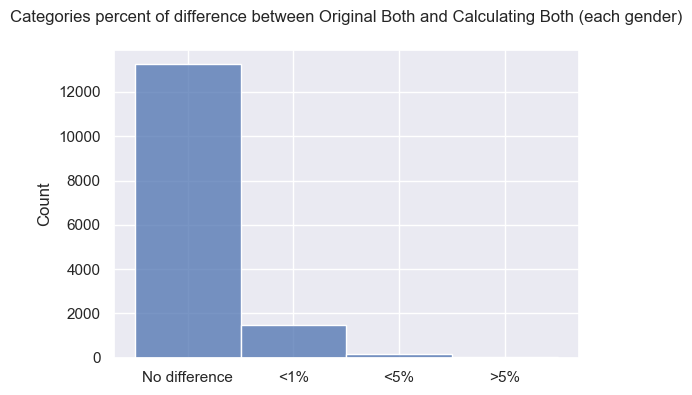

In [18]:
# visualization of the percentages of declared and calculated values of the number of deaths for each sex
sns.set (font_scale=1)
plt.figure(figsize=(6,4))
sns.histplot(comparison_sex_sum['Categories percent of difference'])
plt.xlabel('')
plt.title('Categories percent of difference between Original Both and Calculating Both (each gender)', pad=20)
plt.show()

In [19]:
## final comparison of declared and calculated values

# collection of columns with declared and calculated values into a single dataframe
right_part = comparison_sex_sum.reset_index().iloc[::, [0, 1, 2, 3, 6]].groupby(
    ['Cause of death', 'Country Name','Year']).agg({'Calculating sum of deaths by gender':'sum'}).reset_index()
left_part = find_error_df.iloc[::, 0:5]
conclusion = left_part.merge(right_part, on = ['Cause of death', 'Country Name','Year'])  

# comparison  
conclusion = left_part.merge(right_part, on = ['Cause of death', 'Country Name','Year'])  
(conclusion[(conclusion['Original Both'] == conclusion['Calculating Both'])
            & (conclusion['Calculating Both'] ==
               conclusion['Calculating sum of deaths by gender'])]
 ['Calculating sum of deaths by gender'] == find_error_df[
     find_error_df['Original Both'] == find_error_df['Calculating Both']]
 ['Calculating Both']).value_counts()

True    6304
dtype: int64

Check result:
- In the course of checking the equality of the declared and calculated values of the number of deaths for both sexes, an error was found in the script, 12 files were downloaded, duplicating those downloaded earlier. The reasons affecting the re-download of files have not been identified. The problem was fixed by adding a check of downloaded csv files while the parser was running. The entire amount of data is reloaded;
- In most cases, the reported number of deaths for both sexes is equal to the estimated number. A regularity was revealed, statistics for 53% of countries contain data equal to the calculated ones. The declared data on the number of deaths in the remaining countries do not always (not for every cause of death and year) correspond to the calculated ones. No relationship was found between the presence of discrepancies in values, year and cause of death. The reasons for such phenomena are not indicated in the data on the WHO website;
- In the course of checking the equality of the declared and calculated values of the number of deaths for each sex, a regularity was found. The presence of a difference between the declared and calculated values for individual sexes is observed only in cases where there is also inequality in the total indicator for both sexes.

There are errors in the data, in 12% of the total number of cases, the total values of the number of deaths for a particular sex are incorrectly indicated. In this regard, there are discrepancies in the total number of deaths for both sexes. This problem is seen in data from a limited list of countries and is not related to the year and cause of death. It is not possible to determine the cause of this anomaly. For cases with discrepancies, it is necessary to replace the initially declared data with the calculated ones.

### Null research

In [ ]:
# loading the previously formed dataframe
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')
#df.info()

#### Study of nulls in the indicator "Percentage of cause-specific deaths out of total deaths"

In [21]:
# loading the previously formed dataframe
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')

# which age groups have nulls based on country/year/cause of death/gender
old_len_df_with_nan = len(df[(df['Percentage of cause-specific deaths out of total deaths'].isna())])
df[(df['Percentage of cause-specific deaths out of total deaths'].isna())].groupby(
    ['Cause of death', 'Country Name', 'Year', 'Sex']).agg({'Age Group':'unique'})
df[(df['Cause of death']=='Cardiovascular diseases') & (df['Country Name']=='Iceland') & (df['Year']==2000)]

## nulls were found in the "Percentage of cause-specific deaths out of total deaths" column when there were no deaths

# replacing nulls in the column "Percentage of cause-specifics out of total deaths" with 0.0, provided that the number of deaths is zero
df['Percentage of cause-specific deaths out of total deaths'] = df.apply(
    lambda row: 0.00 if row['Number of deaths'] == 0 \
    else row['Percentage of cause-specific deaths out of total deaths'], axis=1)
df[(df['Cause of death']=='Cardiovascular diseases') & (df['Country Name']=='Iceland') & (df['Year']==2000)]

new_len_df_with_nan = len(df[(df['Percentage of cause-specific deaths out of total deaths'].isna())])
old_len_df_with_nan - new_len_df_with_nan

## the replacement above reduced the number of gaps by 985. There are 4 left

985

In [22]:
# investigation of cases where the value 100 is indicated in the column "Percentage of cause-specific deaths out of total deaths"
df[(df['Percentage of cause-specific deaths out of total deaths']==100)]
df['Percentage of cause-specific deaths out of total deaths'].value_counts(normalize=True)
df[(df['Age Group']!='[All]')]['Percentage of cause-specific deaths out of total deaths'].value_counts(normalize=True)

## in 10% of cases, the value in the "Percentage of cause-specific deaths out of total deaths" column, assuming the age group is different from "[All]", is 100
## a "Percentage of cause-specific deaths out of total deaths" value of 100 for a particular age group, if there are deaths in other age groups, is suspicious

0.000000      0.127697
100.000000    0.100648
25.000000     0.002217
20.000000     0.002149
33.333333     0.001913
                ...   
2.684236      0.000002
1.325890      0.000002
2.076923      0.000002
1.710843      0.000002
2.258422      0.000002
Name: Percentage of cause-specific deaths out of total deaths, Length: 169877, dtype: float64

In [23]:
# cases where the "Percentage of cause- specifics out of total deaths" value is missing when the number of deaths is non-zero
df[(df['Percentage of cause-specific deaths out of total deaths'] == 0) & (df['Number of deaths'] != 0)]

# the total number of cases in which the values in the "Percentage of cause-specific deaths out of total deaths" column are suspicious
amount_of_problem = len(
    df[(df['Percentage of cause-specific deaths out of total deaths'].isna()) | \
       ((df['Percentage of cause-specific deaths out of total deaths'] == 0) & (df['Number of deaths'] != 0)) | \
       ((df['Age Group']!='[All]') & (df['Percentage of cause-specific deaths out of total deaths'] == 100))])

# percentage of cases in which the values in the column "Percentage of cause-specific deaths out of total deaths" are suspicious, of the total number
amount_of_problem * 100 / len(df) 

9.562382360849691

Research result

In more than 9.5% of cases, the value in the "Percentage of cause-specific deaths out of total deaths" column is suspicious for the following reasons: 
- lack of value;
- equality to zero, if the number of deaths is different from zero;
- equal to 100, if the value of the age group is different from "[All]".

Due to the lack of a description and principles for calculating this parameter on the WHO resource, it is not possible to verify the correctness of suspicious values. This column needs to be removed.

#### Exploring gaps in "Age-standardized death rate per 100,000 standard population"

In [24]:
# loading the previously formed dataframe 
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')

# looking for patterns in missing values in the "Age-standardized death rate per 100,000 standard population" column
df[df['Age-standardized death rate per 100 000 standard population'].isna()]
df[(df['Age Group']!='[All]') & (df['Age-standardized death rate per 100 000 standard population'].isna())]
df[(df['Age Group']!='[All]') & (df['Age-standardized death rate per 100 000 standard population'].notna())]
len(df[(df['Age Group']=='[All]') & (df['Age-standardized death rate per 100 000 standard population'].isna())])

## all available values in the "Age-standardized death rate per 100,000 standard population" column are relevant for cases in the "[All]" age group

df[(df['Age Group']=='[All]') & (df['Age-standardized death rate per 100 000 standard population'].isna())]

## in 15 cases, with the age group "[All]", the value "Age-standardized death rate per 100,000 standard population" is not specified

,Cause of death,Country Code,Country Name,Year,Sex,Age Group,Number of deaths,Death rate per 100 000 population,Percentage of cause-specific deaths out of total deaths,Age-standardized death rate per 100 000 standard population
3000,All causes,BEL,Belgium,2004,Unknown,[All],3.0,NaN,100.000000,NaN
3260,All causes,BEL,Belgium,2008,Unknown,[All],1.0,NaN,100.000000,NaN
14080,All causes,DEU,Germany,2017,Unknown,[All],9.0,NaN,100.000000,NaN
15540,All causes,GRC,Greece,2020,Unknown,[All],7.0,NaN,100.000000,NaN
31280,All causes,PRT,Portugal,2010,Unknown,[All],1.0,NaN,100.000000,NaN
31360,All causes,PRT,Portugal,2011,Unknown,[All],3.0,NaN,100.000000,NaN
31500,All causes,PRT,Portugal,2013,Unknown,[All],1.0,NaN,100.000000,NaN
31820,All causes,PRT,Portugal,2018,Unknown,[All],1.0,NaN,100.000000,NaN
48040,Cardiovascular diseases,BEL,Belgium,2004,Unknown,[All],2.0,NaN,66.666667,NaN
48300,Cardiovascular diseases,BEL,Belgium,2008,Unknown,[All],1.0,NaN,100.000000,NaN


Research result:

The values in the "Age-standardized death rate per 100,000 standard population" column are for the "[All]" age group only, with the exception of 15 missing values for the "Unknown" gender.


#### Study of nulls in the indicator "Death rate per 100,000 population"

In [25]:
# loading the previously formed dataframe
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')

# looking for patterns in missing values in the "Death rate per 100,000 population" column
df[(df['Death rate per 100 000 population'].isna())]
df[(df['Death rate per 100 000 population'].isna()) & (df['Sex']!='Unknown')]

## all missing values are associated with the "Unknown" gender

# number of cases with sex "Unknown"
len(df[df['Sex']=='Unknown'])

300

Research result:

Missing values in the "Death rate per 100,000 population" column are related to the "Unknown" gender.

As a result of the study of gaps in the columns "Percentage of cause-specific deaths out of total deaths", "Age-standardized death rate per 100,000 standard population", "Death rate per 100,000 population" the decision was made:
- remove the column "Percentage of cause-specific deaths out of total deaths";
- Reject the "Unknown" gender. Distribute the number of deaths of the sex "Unknown" between the sexes "Male" and "Female" in the appropriate percentages;
- recalculate the corresponding indicators "Age-standardized death rate per 100,000 standard population", "Death rate per 100,000 population".

## Data processin

#### Refusal to use the "Unknown" gender. Proportional distribution of deaths of the sex "Unknown" between the sexes "Male" and "Female". Removing the "Percentage of cause-specific deaths out of total deaths" column

In [40]:
# loading the previously formed dataframe  
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')

# remove the "Percentage of cause-specific deaths out of total deaths" column
df = df.iloc[::, [0, 1, 2, 3, 4, 5, 6, 7, 9]]

# proportional distribution of deaths of the sex "Unknown" between the sexes "Male" and "Female"
list_of_strings_with_Unknown_Sex = list(df[df['Sex'] == 'Unknown'].index)
list_of_num_changed_str = []  
for i in list_of_strings_with_Unknown_Sex:
    if df['Age Group'][i] != '[All]' and df['Number of deaths'][i] != 0:
        # calculating the number of deaths to be added by gender "Male" и "Female"
        female = df[(df['Cause of death'] == df['Cause of death'][i]) & (df['Country Name'] == df['Country Name'][i]) & \
                    (df['Year'] == df['Year'][i]) & (df['Age Group'] == df['Age Group'][i]) & (df['Sex'] == 'Female')]
        male = df[(df['Cause of death'] == df['Cause of death'][i]) & (df['Country Name'] == df['Country Name'][i]) & \
                  (df['Year'] == df['Year'][i]) & (df['Age Group'] == df['Age Group'][i]) & (df['Sex'] == 'Male')]
        total = int(float(male['Death rate per 100 000 population']) + \
                    float(female['Death rate per 100 000 population']))
        need_to_add_for_max = 0
        need_to_add_for_min = 0

        need_to_add_for_max = int(int(df['Number of deaths'][i]) * max(
            float(male['Death rate per 100 000 population']), float(female['Death rate per 100 000 population']))/total)
        need_to_add_for_max += 1

        need_to_add_for_min = int(int(df['Number of deaths'][i]) * min(
            float(male['Death rate per 100 000 population']), float(female['Death rate per 100 000 population']))/total)
        
        # collecting information about where the changes were made 
        list_of_num_changed_str.append((df['Cause of death'][i],  df['Country Name'][i],  df['Year'][i]))

        # changing the number of deaths for the sexes "Male" and "Female" based on the above calculations
        # definition of line numbers for the corresponding age group of sexes "Male" and "Female"
        num_of_str_max = (
            df[(df['Cause of death'] == df['Cause of death'][i])
               & (df['Country Name'] == df['Country Name'][i]) &
               (df['Year'] == df['Year'][i]) & (df['Age Group'] == df['Age Group'][i])
               & (df['Death rate per 100 000 population'] == max(
                   float(male['Death rate per 100 000 population']),
                   float(female['Death rate per 100 000 population'])))].index)[0]
        num_of_str_min = (
            df[(df['Cause of death'] == df['Cause of death'][i])
               & (df['Country Name'] == df['Country Name'][i]) &
               (df['Year'] == df['Year'][i]) & (df['Age Group'] == df['Age Group'][i])
               & (df['Death rate per 100 000 population'] == min(
                   float(male['Death rate per 100 000 population']),
                   float(female['Death rate per 100 000 population'])))].index)[0]
        
        # work with the "Number of deaths" column
        # fixing the initial values for the sexes "Male" and "Female"
        old_max_Number_of_deaths = df['Number of deaths'][num_of_str_max] 
        old_min_Number_of_deaths = df['Number of deaths'][num_of_str_min]
        
        # calculation of new values for sexes "Male" and "Female"
        new_max_Number_of_deaths = df['Number of deaths'][num_of_str_max] + need_to_add_for_max
        new_min_Number_of_deaths = df['Number of deaths'][num_of_str_min] + need_to_add_for_min
        
        # setting new values
        df.at[num_of_str_max, 'Number of deaths'] = new_max_Number_of_deaths
        df.at[num_of_str_min, 'Number of deaths'] = new_min_Number_of_deaths
        
        # work with the column "Death rate per 100 000 population"
        # fixing the initial values for the sexes "Male" and "Female"
        old_max_Death_100 = df['Death rate per 100 000 population'][num_of_str_max] 
        old_min_Death_100 = df['Death rate per 100 000 population'][num_of_str_min]
        
        # calculation of new values for sexes "Male" and "Female"
        new_max_Death_100 = new_max_Number_of_deaths * old_max_Death_100 / old_max_Number_of_deaths
        new_min_Death_100 = new_min_Number_of_deaths * old_min_Death_100 / old_min_Number_of_deaths
        
        # set new values
        df.at[num_of_str_max, 'Death rate per 100 000 population'] = new_max_Death_100
        df.at[num_of_str_min, 'Death rate per 100 000 population'] = new_min_Death_100
                     
# deleting cases with sex "Unknown"
df = df[(df['Sex'] != 'Unknown')]

#### Replacing indicators of the columns "Number of deaths", "Death rate per 100 000 population", "Age-standardized death rate per 100 000 standard population" of the age group "All" for the sexes "Male" and "Female" that do not correspond to the calculated values

In [41]:
# calculation of the number of deaths for each gender
sex_sum_no_both = df[(df['Sex'] != 'Both') & (df['Age Group'] != '[All]')]
sex_sum_no_both = sex_sum_no_both.groupby(['Cause of death', 'Country Name', 'Year', 'Sex']).agg({'Number of deaths':'sum'})
sex_sum_no_both = sex_sum_no_both.rename(columns = {'Number of deaths':'Calculating sum of deaths by gender'})

# comparison of reported and calculated values of the number of deaths for each sex
sex_sum_original_no_both = df[(df['Sex'] != 'Both') & (df['Age Group'] == '[All]')].reset_index().set_index(
    ['Cause of death','Country Name','Year','Sex'])               
sex_sum_original_no_both = sex_sum_original_no_both.rename(columns={'Number of deaths':'Original sum of deaths by gender'})
len(sex_sum_original_no_both) == len(sex_sum_no_both)
comparison_sex_sum_no_both = sex_sum_original_no_both.merge(
    sex_sum_no_both, how = 'left', right_index=True, left_index=True)
comparison_sex_sum_no_both['Comparison'] = (
    comparison_sex_sum_no_both['Original sum of deaths by gender'] == \
    comparison_sex_sum_no_both['Calculating sum of deaths by gender'])

list_of_num_str_need_upd_no_both = list(
    comparison_sex_sum_no_both [comparison_sex_sum_no_both['Comparison'] == False]['index'])
comparison_sex_sum_no_both = comparison_sex_sum_no_both.reset_index().set_index(['index'])

for i in list_of_num_str_need_upd_no_both:
    # adjusting "Number of deaths" values
    df.at[i, 'Number of deaths'] = comparison_sex_sum_no_both['Calculating sum of deaths by gender'][i]
    
    # adjusting "Death rate per 100,000 population" values
    df.at[i, 'Death rate per 100 000 population'] = comparison_sex_sum_no_both['Death rate per 100 000 population'][i] * \
    comparison_sex_sum_no_both['Calculating sum of deaths by gender'][i] / \
    comparison_sex_sum_no_both['Original sum of deaths by gender'][i]
    
    # adjusting "Age-standardized death rate per 100,000 standard population" values
    df.at[i, 'Age-standardized death rate per 100 000 standard population'] = \
    comparison_sex_sum_no_both['Age-standardized death rate per 100 000 standard population'][i] * \
    comparison_sex_sum_no_both['Calculating sum of deaths by gender'][i] / \
    comparison_sex_sum_no_both['Original sum of deaths by gender'][i]

#### Replacing indicators of the "Number of deaths", "Death rate per 100 000 population", "Age-standardized death rate per 100 000 standard population" columns of the "All" age group for the "Both" sex that do not correspond to the calculated values

In [42]:
# calculation of the number of deaths by both sexes
sex_sum_both = df[(df['Sex'] != 'Both') & (df['Age Group'] == '[All]') & (df['Sex'] != 'Unknown')].groupby(
    ['Cause of death', 'Country Name', 'Year']).agg({'Number of deaths':'sum'}).reset_index() 
sex_sum_both = sex_sum_both.rename(columns = {'Number of deaths':'Calculating sum of deaths by gender'})

# comparison of reported and calculated values of the number of deaths for both sexes
sex_sum_original_both = df[(df['Sex'] == 'Both') & (df['Age Group'] == '[All]')].reset_index()
sex_sum_original_both = sex_sum_original_both.rename(columns = {'Number of deaths':'Original sum of deaths by gender'})
comparison_sex_sum_both = sex_sum_original_both.merge(sex_sum_both, on = ['Country Name', 'Cause of death', 'Year'])  
list_of_num_str_need_upd_both = list(
    comparison_sex_sum_both[comparison_sex_sum_both['Original sum of deaths by gender'] != \
                            comparison_sex_sum_both['Calculating sum of deaths by gender']]['index'])
comparison_sex_sum_both = comparison_sex_sum_both.set_index(['index'])

for i in list_of_num_str_need_upd_both:
    # adjusting "Number of deaths" values
    df.at[i, 'Number of deaths'] = comparison_sex_sum_both['Calculating sum of deaths by gender'][i]
    
    # adjusting "Death rate per 100,000 population" values
    df.at[i, 'Death rate per 100 000 population'] = comparison_sex_sum_both['Death rate per 100 000 population'][i] * \
    comparison_sex_sum_both['Calculating sum of deaths by gender'][i] / \
    comparison_sex_sum_both['Original sum of deaths by gender'][i]
    
    # adjusting "Age-standardized death rate per 100,000 standard population" values
    df.at[i, 'Age-standardized death rate per 100 000 standard population'] = \
    comparison_sex_sum_both['Age-standardized death rate per 100 000 standard population'][i] * \
    comparison_sex_sum_both['Calculating sum of deaths by gender'][i] / \
    comparison_sex_sum_both['Original sum of deaths by gender'][i]

#### Check after replacement

In [43]:
# check age group "[All]" for sexes "Male" and "Female"
count_sex_sum = df[(df['Sex'] != 'Both') & (df['Age Group'] != '[All]')].groupby(
    ['Cause of death', 'Country Name', 'Year', 'Sex']).agg({'Number of deaths':'sum'}).rename(
    columns={'Number of deaths': 'Calculating Number of deaths'})
all_sex_sum = df[(df['Sex'] != 'Both') & (df['Age Group'] == '[All]')].set_index(
    ['Cause of death','Country Name','Year','Sex'])              
test_res = all_sex_sum.merge(count_sex_sum, right_index=True, left_index=True)  
len(test_res[test_res['Number of deaths'] != test_res['Calculating Number of deaths']])

## there are no cases of inequality between the specified total value and the actual amount for all age groups of the sexes "Male" and "Female"

# check age group "[All]" for gender "Both"
count_sex_sum_both = df[(df['Sex'] != 'Both') & (df['Age Group'] == '[All]')].groupby(
    ['Cause of death', 'Country Name', 'Year']).agg({'Number of deaths':'sum'}).rename(
    columns={'Number of deaths': 'Calculating both Number of deaths'})
all_sex_sum_both = df[(df['Sex'] == 'Both') & (df['Age Group'] == '[All]')].set_index(
    ['Cause of death','Country Name','Year','Sex'])              
test_res_both = all_sex_sum_both.merge(count_sex_sum_both, right_index=True, left_index=True) 
test_res_both
len(test_res_both[test_res_both['Number of deaths'] != test_res_both['Calculating both Number of deaths']])

## there are no cases of inequality between the specified total value and the actual amount for both sexes

# check match against original dataframe
# previously recorded number of rows with discrepancies between the calculated and declared values
len_error_old = len(find_error_df[find_error_df['Original Both equals Calculating Both'] == False])

# comparison of the processed dataframe with the original 
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe_before_checking.csv", encoding='utf-8')
df_before = df_before.iloc[::, [0, 1, 2, 3, 4, 5, 6, 7, 9]]
count_sex_sum_both_old = df_before[(df_before['Sex'] != 'Both') & (df_before['Age Group'] == '[All]')].groupby(
    ['Cause of death', 'Country Name', 'Year']).agg({'Number of deaths':'sum'}).rename(
    columns={'Number of deaths': 'Calculating both Number of deaths'})
test_res_both_end = all_sex_sum_both.merge(count_sex_sum_both_old, right_index=True, left_index=True) 
len(test_res_both_end[test_res_both_end['Number of deaths'] != test_res_both_end['Calculating both Number of deaths']]) == len_error_old

## initially recorded number of rows with discrepancies is equal to the discrepancy between the original dataframe and the processed one

True

In [44]:
# saving the processed dataframe
path_to_file_with_total_frame_after_checking = path_to_new_folder_with_data + \
    f'\\WHO_MORTALITY_DATABASE_total_dataframe.csv'
df.to_csv(path_to_file_with_total_frame_after_checking, index=False)

Processing the result:

- removed column "Percentage of cause-specific deaths out of total deaths";
- distribution of the number of deaths of the sex "Unknown" between the sexes "Male" and "Female" was carried out in the appropriate percentages;
- the corresponding indicators "Age-standardized death rate per 100,000 standard population", "Death rate per 100,000 population" have been recalculated.

The check carried out by processing the dataframe demonstrated the correctness of the changes made. The processed datafree is saved.


## Preparing data for creating a dashboard

In [13]:
# loading the previously formed dataframe
df = pd.read_csv(
    r"tabs\WHO_MORTALITY_DATABASE_total_dataframe.csv", encoding='utf-8')

In [ ]:
## define a filter 
## country-specific statistics will only be taken into account if data were provided on 15 or more occasions during the reporting period
a = df.groupby(['Cause of death','Country Name']).agg({'Year':'nunique'})
a = a[a['Year']>=15].reset_index().groupby(['Cause of death']).agg({'Country Name':'unique'})['Country Name']

In [ ]:
# define the indexes of the rows that need to be deleted necessary
n_need = []
for i in tqdm(range(445980)):
    if df.iloc[i, ::]['Country Name'] not in a[df.iloc[i, ::]['Cause of death']]:
        n_need.append(i)

# delete 
df = df.drop(n_need).reset_index(drop=True)

# check 
a = df.groupby(['Cause of death','Country Name']).agg({'Year':'nunique'})
a[a['Year']<15]
## passed, for each cause of death, only those countries that provided statistics at least 15 times during the reporting period are considered

In [16]:
# save as .csv
path_to_file_with_total_frame_after_checking = path_to_new_folder_with_data + \
    f'\\WHO_MORTALITY_DATABASE_total_dataframe_Dashboard.csv'
df.to_csv(path_to_file_with_total_frame_after_checking, index=False)

The result of preparing data for the creation of a dashboard: data related to countries that submitted statistics less than 15 times during the reporting period were excluded from the dataframe.